In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('/home/briggsc1-erau.edu/Downloads/housing.csv')
features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income']
target = ['median_house_value']
df = df.dropna(subset = features+target)

In [3]:
x_tr,x_te,y_tr,y_te = train_test_split(df[features],df[target],
                                       test_size = 0.4, random_state = 0)
x_va,x_te,y_va,y_te = train_test_split(x_te,y_te,
                                       test_size = 0.5, random_state = 0)

First, we get the depth of an unconstrainted tree to use as an upper bound on depth in our parameter search.

In [4]:
tr = DecisionTreeRegressor(random_state = 0)
tr.fit(x_tr,y_tr)
ud = tr.get_depth()

What we'll do is vary max_depth from 1 to the upper bound we found, vary min_samples_leaf from 1 to 12, and vary criterion.

In [27]:
%%timeit
# how long do these trees take to train tho?
crit = 'poisson'
i = 15
j = 1
tr = DecisionTreeRegressor(criterion = crit,max_depth = i,
                           min_samples_leaf=j,random_state = 0)
tr.fit(x_tr,y_tr)

69.9 ms ± 117 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [28]:
data = [] # a list to hold dictionaries for conversion to a dataframe
depth_lower = 1 # set a lower bound for the max tree depth
for i in range(depth_lower,ud+1):
    for j in range(1,13):
        # absolute_error is getting horrible performance! drop it, and write sklearn a nasty letter
        for crit in ['squared_error','friedman_mse','poisson']:#, 'absolute_error',]: # depending on sklearn.__verison__, may need to change
            tr = DecisionTreeRegressor(criterion = crit,max_depth = i,min_samples_leaf=j,random_state = 0)
            tr.fit(x_tr,y_tr)
            train_score = tr.score(x_tr,y_tr)
            val_score = tr.score(x_va,y_va)
            num_leaves = tr.get_n_leaves()
            data.append({'crit':crit,'set':'train','score':train_score,
                         'num_leaves':num_leaves,'depth':i,'min_samples':j})
            data.append({'crit':crit,'set':'val','score':val_score,
                         'num_leaves':num_leaves,'depth':i,'min_samples':j})
df_acc = pd.DataFrame(data)
# create a multi-indexed dataframe
multi = df_acc.set_index(['set','crit','depth','min_samples'])
multi = multi.sort_index()

We've run into a situation where we just don't have the computing power necessary to complete our intended workflow. One thing we could do is see exactly what we're up against by estimating and displaying progress as this cell executes. Would it finish in an hour? A year? A billion years? For now we'll devise workarounds.

Standard approaches include

- coarsen the search space: count parameters by 2 or 5 instead of 1
  - this should be followed by refined searches in the region of the revealed optimum
- get more processing power (including multithreading)
- lighten the load by decreasing the training set size

The third option is perhaps the crudest, but it's also the easiest to execute. So let's go back to the top and reduce the size of the training set.

We'll make a series of plots to compare two criteria side-by-side for various max_depths and min_samples_leaf. Change crit1 and crit2 to various criteria to compare them.

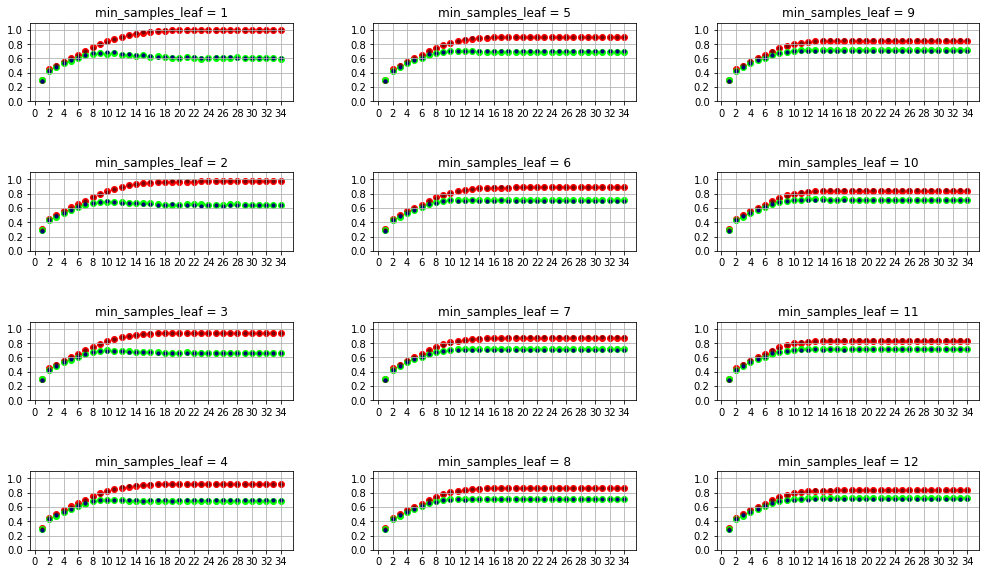

In [38]:
crit1 = 'squared_error'
crit2 = 'poisson'
fig,axes = plt.subplots(4,3,figsize = (15,9))
fig.tight_layout(pad=5.0)
for j in range(12):
    axes[j%4,j//4].scatter(range(depth_lower,ud+1),multi.loc[('train',crit1,slice(None),j+1)].score,
            color = '#FF0000')
    axes[j%4,j//4].scatter(range(depth_lower,ud+1),multi.loc[('val',crit1,slice(None),j+1)].score,
            color = '#00FF00')
    axes[j%4,j//4].scatter(range(depth_lower,ud+1),multi.loc[('train',crit2,slice(None),j+1)].score,
            color = '#770000',s = 10)
    axes[j%4,j//4].scatter(range(depth_lower,ud+1),multi.loc[('val',crit2,slice(None),j+1)].score,
            color = '#000077',s = 10)
    axes[j%4,j//4].set_title(f'min_samples_leaf = {j+1}')
    axes[j%4,j//4].grid()
    axes[j%4,j//4].set_xticks(range(0,ud+1,2))
    axes[j%4,j//4].set_ylim(0,1.1)
    axes[j%4,j//4].set_yticks(np.linspace(0,1,6))
plt.show();